In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
from itertools import product

In [2]:
data = pd.read_csv('non-parametric.csv', sep = ';').as_matrix()
datax = data[:, 1]
datay = data[:, -1]

In [3]:
def f(x, y):
    return y if -1 <= x <= 1 else 0
def uniform(x):
    return f(x, 0.5)
def triangle(x):
    return f(x, 1 - x)
def epanechnikov(x):
    return f(x, 3 / 4 * (1 - x ** 2))
def quartic(x):
    return f(x, 15 / 16 * (1 - x ** 2) ** 2)
def triweight(x):
    return f(x, 35 / 32 * (1 - x ** 2) ** 3)
def gaussian(x):
    return math.e ** (-1 / 2 * x ** 2) / (2 * math.pi) ** 0.5
def cosine(x):
    return f(x, math.pi / 4 * math.cos(x / 2 * math.pi))
LOWESS_kernel = lambda u: (1 - u ** 2) ** 2 * (abs(u) <= 1)

In [4]:
def get_weights1(x, X, kernel, h, i):
    return np.array([kernel((x - xt) / h) for j, xt in enumerate(X) if j != i])

In [5]:
def get_weights(x, X, kernel, h):
    return np.array([kernel((x - xt) / h) for xt in X])

In [6]:
class kNN:
    def __init__(self, k, kernel):
        self.k = k
        self.kernel = kernel
    def fit(self, X, Y):
        self.X = X
        self.Y = Y
    def predict(self, x):
        x_sort, y_sort = zip(*sorted(zip(self.X, self.Y), key = lambda xy: abs(x - xy[0])))
        h = abs(x_sort[self.k - 1] - x)
        ws = get_weights(x, self.X, self.kernel, h)
        
        if sum(ws) == 0:
            return sum(y_sort[:self.k]) / self.k
        return np.inner(ws, self.Y) / sum(ws)

In [7]:
def MSE(y_true, y):
    return sum((y_true - y) ** 2 / len(y))
def RMSE(y_true, y):
    return sum((y_true - y) ** 2 / len(y)) ** 0.5

In [8]:
def loo(X, Y, model, params):
    y_pred = []
    for i in range(len(X)):
        m = model(**params)
        m.fit(np.delete(X, i, axis = 0), np.delete(Y, i, axis = 0))
        y_pred.append(m.predict(X[i]))
    return MSE(Y, y_pred)

In [9]:
class GridSearch:
    def __init__(self, model, params):
        self.model = model
        self.params = params
    def fit(self, X, Y):
        pkeys = self.params.keys()
        pvalues = list(product(*self.params.values()))
        res = []
        
        for v in pvalues:
            local_ps = dict(zip(pkeys, v))
            l_items = local_ps.copy()
            res.append((loo(X, Y, self.model, local_ps), l_items))
        minv = 1e10
        for loov, ps in res:
            if loov < minv:
                minv = loov
                self.best_params = ps
                self.best_error = loov
        return res

In [10]:
def getLineWithoutOne(model, X, Y, params):
    y_pred = []
    for i in range(len(X)):
        m = model(**params)
        m.fit(X, Y)
        y_pred.append(m.predict(X[i]))
        
    return list(zip(*sorted(zip(X, y_pred))))

In [11]:
def getLineOnGrid(interval, step, method, X, Y, args):
    y_pred = []
    args['X'] = X
    args['Y'] = Y
    for x in np.arange(interval[0], interval[1], step):
        y_pred.append(method(x, **args))        
    return zip(*sorted(zip(X, y_pred)))

In [12]:
class lowess:
    def __init__(self, h, kernel):
        self.h = h
        self.kernel = kernel
        
    def fit(self, X, Y):
        delta = np.ones((len(X), ), dtype = float)
        self.X = X
        self.Y = Y
        for _ in range(3):
            y_pred = []        
            for i in range(len(X)):            
                ws = get_weights1(X[i], X, self.kernel, self.h, i)
                ws = np.insert(ws, i, 1, axis = 0)
                ws = ws * delta
                ws = np.delete(ws, i, axis = 0)
                y_pred.append(np.inner(ws, np.delete(Y, i, axis = 0)) / sum(ws))
                
            s = np.median(abs(y_pred - Y))
            eps = abs(y_pred - Y)
            delta = LOWESS_kernel(eps / (6.0 * s))     
        self.delta = delta
        
    def predict(self, x):
        ws = get_weights(x, self.X, self.kernel, self.h)
        ws = ws * self.delta
        if sum(ws) == 0:
            print('asdasd')
        return np.inner(ws, self.Y) / sum(ws)

kNN best params: {'k': 21, 'kernel': <function quartic at 0x7fcfde810598>} MSE: 899.9869503034543


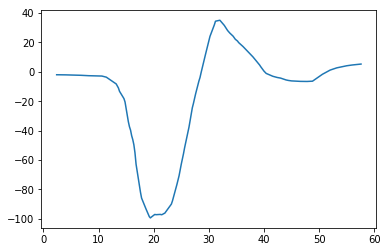

In [13]:
params = {'k' : list(range(15, 25)),
          'kernel' : [quartic]
         }
gr = GridSearch(kNN, params)
gr.fit(datax, datay)
best_ps = gr.best_params
best_err = gr.best_error

print('kNN best params:', best_ps, 'MSE:', best_err)
line = getLineWithoutOne(kNN, datax, datay, best_ps)
plt.plot(line[0], line[1], label = 'kNN')
plt.show()

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in less_equal


lowess best params: {'h': 3, 'kernel': <function triweight at 0x7fcfde810510>} MSE: 921.9053896173297


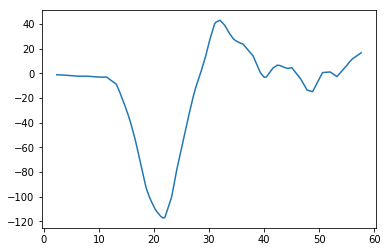

In [14]:
params = {'h' : np.arange(2, 4, 1),
          'kernel' : [triweight]
         }
gr = GridSearch(lowess, params)
gr.fit(datax, datay)
best_ps = gr.best_params
best_err = gr.best_error

print('lowess best params:', best_ps, 'MSE:', best_err)
line = getLineWithoutOne(lowess, datax, datay, best_ps)
plt.plot(line[0], line[1], label = 'lowess')

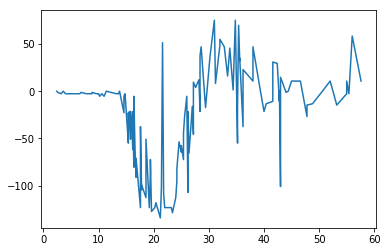

In [15]:
line = list(zip(*sorted(zip(datax, datay))))
plt.plot(*line)